# Web Mining Final Project:

## Pavan Kumar Reddy Byreddy:

# Most Common Words in Amazon Product Reviews and Product Rating Comparison

### Question: 
        What are most common words in the reviews of Amazon product and compare the rating of the products

The main purpose of this project is to find the most common words in the customer reviews of different products on amazon shopping and also comparing their customer ratings.


I have used below products as my sample data.

- JBL E45BT On-Ear Wireless Headphones
- Skullcandy Inked Bluetooth Wireless
- Sony WH1000XM3 Bluetooth Wireless

## Procedure

### Step 1: Defining a method for Web Scarping the data from Amazon website. (Input: URL, Output: Information about product)

In [1]:
from requests import get
from lxml import html
from re import sub
from dateutil import parser as dateparser
from time import sleep

def ExtractDataFromURL(amazon_url):
    
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
    for i in range(5):
        response = get(amazon_url, headers = headers, verify=False, timeout=30)
        if response.status_code == 404:
            return {"url": amazon_url, "error": "page not found"}
        if response.status_code != 200:
            continue
        
        # Removing the null bytes from the response.
        cleaned_response = response.text.replace('\x00', '')
        
        parser = html.fromstring(cleaned_response)
        XPATH_REVIEW_SECTION_1 = '//div[contains(@id,"reviews-summary")]'
        XPATH_REVIEW_SECTION_2 = '//div[@data-hook="review"]'
        XPATH_AGGREGATE_RATING = '//table[@id="histogramTable"]//tr'
        XPATH_PRODUCT_NAME = '//h1//span[@id="productTitle"]//text()'
        XPATH_PRODUCT_PRICE = '//span[@id="priceblock_ourprice"]/text()'

        raw_product_price = parser.xpath(XPATH_PRODUCT_PRICE)
        raw_product_name = parser.xpath(XPATH_PRODUCT_NAME)
        total_ratings  = parser.xpath(XPATH_AGGREGATE_RATING)
        reviews = parser.xpath(XPATH_REVIEW_SECTION_1)

        product_price = ''.join(raw_product_price).replace(',', '')
        product_name = ''.join(raw_product_name).strip()

        if not reviews:
            reviews = parser.xpath(XPATH_REVIEW_SECTION_2)
        ratings_dict = {}
        reviews_list = []

        # Grabing the rating  section in product page
        for ratings in total_ratings:
            extracted_rating = ratings.xpath('./td//a//text()')
            if extracted_rating:
                rating_key = extracted_rating[0] 
                raw_raing_value = extracted_rating[1]
                rating_value = raw_raing_value
                if rating_key:
                    ratings_dict.update({rating_key: rating_value})
        
        # Parsing individual reviews
        for review in reviews:
            XPATH_RATING  = './/i[@data-hook="review-star-rating"]//text()'
            XPATH_REVIEW_HEADER = './/a[@data-hook="review-title"]//text()'
            XPATH_REVIEW_POSTED_DATE = './/span[@data-hook="review-date"]//text()'
            XPATH_REVIEW_TEXT_1 = './/div[@data-hook="review-collapsed"]//text()'
            XPATH_REVIEW_TEXT_2 = './/div//span[@data-action="columnbalancing-showfullreview"]/@data-columnbalancing-showfullreview'
            XPATH_REVIEW_COMMENTS = './/span[@data-hook="review-comment"]//text()'
            XPATH_AUTHOR = './/span[contains(@class,"profile-name")]//text()'
            XPATH_REVIEW_TEXT_3 = './/div[contains(@id,"dpReviews")]/div/text()'
            
            raw_review_author = review.xpath(XPATH_AUTHOR)
            raw_review_rating = review.xpath(XPATH_RATING)
            raw_review_header = review.xpath(XPATH_REVIEW_HEADER)
            raw_review_posted_date = review.xpath(XPATH_REVIEW_POSTED_DATE)
            raw_review_text1 = review.xpath(XPATH_REVIEW_TEXT_1)
            raw_review_text2 = review.xpath(XPATH_REVIEW_TEXT_2)
            raw_review_text3 = review.xpath(XPATH_REVIEW_TEXT_3)

            # Cleaning data
            author = ' '.join(' '.join(raw_review_author).split())
            review_rating = ''.join(raw_review_rating).replace('out of 5 stars', '')
            review_header = ' '.join(' '.join(raw_review_header).split())

            try:
                review_posted_date = dateparser.parse(''.join(raw_review_posted_date)).strftime('%d %b %Y')
            except:
                review_posted_date = None
            review_text = ' '.join(' '.join(raw_review_text1).split())

            # Grabbing hidden comments if present
            if raw_review_text2:
                json_loaded_review_data = loads(raw_review_text2[0])
                json_loaded_review_data_text = json_loaded_review_data['rest']
                cleaned_json_loaded_review_data_text = re.sub('<.*?>', '', json_loaded_review_data_text)
                full_review_text = review_text+cleaned_json_loaded_review_data_text
            else:
                full_review_text = review_text
            if not raw_review_text1:
                full_review_text = ' '.join(' '.join(raw_review_text3).split())

            raw_review_comments = review.xpath(XPATH_REVIEW_COMMENTS)
            review_comments = ''.join(raw_review_comments)
            review_comments = sub('[A-Za-z]', '', review_comments).strip()
            review_dict = {
                                'review_comment_count': review_comments,
                                'review_text': full_review_text,
                                'review_posted_date': review_posted_date,
                                'review_header': review_header,
                                'review_rating': review_rating,
                                'review_author': author

                            }
            reviews_list.append(review_dict)

        data = {
                    'ratings': ratings_dict,
                    'reviews': reviews_list,
                    'url': amazon_url,
                    'name': product_name,
                    'price': product_price
                
                }
        return data

    return {"error": "failed to process the page", "url": amazon_url}

### Step 2: Defining the URL's and passing them to above method to get the extracted data about the product

In [2]:
productList = ['https://www.amazon.com/dp/B01MZZWYLQ/ref=psdc_12097479011_t2_B01N7CV2TS', 
            'https://www.amazon.com/Skullcandy-Bluetooth-Microphone-Rechargeable-Lightweight/dp/B07DGJRVL2/ref=sr_1_10?crid=3QPCHVVSPN0ZE&keywords=skullcandy+wireless+headphones&qid=1561856449&s=gateway&sprefix=skull%2Caps%2C167&sr=8-10', 
            'https://www.amazon.com/Sony-WH1000XM3-Headphones-WH-1000XM3-Refurbished/dp/B07HJ87WJD/ref=asc_df_B07HJ87WJD/?tag=hyprod-20&linkCode=df0&hvadid=241989349889&hvpos=1o2&hvnetw=g&hvrand=9316757902759845659&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9023314&hvtargid=pla-571879574358&psc=1']
extracted_data = []
   
for product in productList:
    extracted_data.append(ExtractDataFromURL(product))
    sleep(5)


C:\Users\s534625\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\Users\s534625\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\Users\s534625\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


### Step 3: Visualizing the most common words from the extracted reviews using Word Cloud


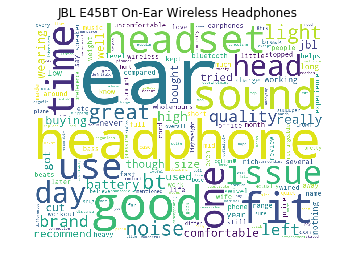

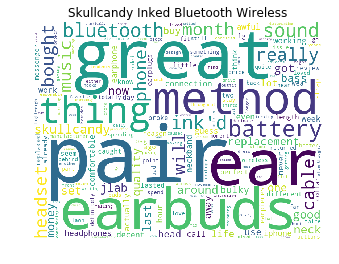

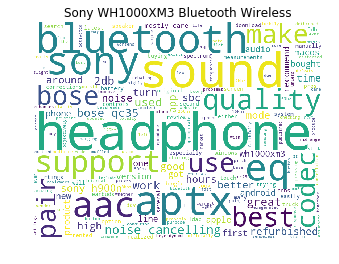

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

count=1
titles=["JBL E45BT On-Ear Wireless Headphones","Skullcandy Inked Bluetooth Wireless","Sony WH1000XM3 Bluetooth Wireless"]
for reviewData in extracted_data:
    words=" "
    plt.figure(count)
    plt.title(titles[count-1])
    for msg in reviewData["reviews"]:
        msg = str(msg["review_text"]).lower()
        words = words+msg+" "
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(words)
    count=count+1
    plt.imshow(wordcloud) 
    plt.axis("off")
plt.show()

### Step 4: Visualize the rating of the products

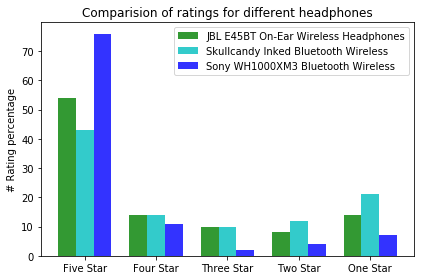

In [12]:
import numpy as np

ratings={1:[],2:[],3:[]}
lencount=1
for reviewData in extracted_data: 
    ratings[lencount].append(int(reviewData["ratings"]["5 star"][:-1]))
    ratings[lencount].append(int(reviewData["ratings"]["4 star"][:-1]))
    ratings[lencount].append(int(reviewData["ratings"]["3 star"][:-1]))
    ratings[lencount].append(int(reviewData["ratings"]["2 star"][:-1]))
    ratings[lencount].append(int(reviewData["ratings"]["1 star"][:-1]))
    lencount=lencount+1
    

fig = plt.figure(count)
n=5
index=np.arange(n)
barwidth=0.25
opacity=0.8


objects=('Five Star','Four Star','Three Star','Two Star','One Star')

bar1 = plt.bar(index, ratings[1], barwidth,
alpha=opacity,
color='g',
label='JBL E45BT On-Ear Wireless Headphones')

bar2 = plt.bar(index + barwidth, ratings[2], barwidth,
alpha=opacity,
color='c',
label='Skullcandy Inked Bluetooth Wireless')


bar3 = plt.bar(index +barwidth+ barwidth, ratings[3], barwidth,
alpha=opacity,
color='b',
label='Sony WH1000XM3 Bluetooth Wireless')



plt.xticks(index + barwidth,objects)
plt.ylabel('# Rating percentage')
plt.title('Comparision of ratings for different headphones')

plt.legend()
plt.tight_layout()

plt.show()


## Conclusion:

From the results, I can conclude that the most common words for different headphones are related to their properties and various attributes such as sound, quality etc.

The most common words that stand out in the reviews also indicate the ratings. Here, from the comparison of ratings we can easily compare the ratings of the different products.

If product has more five stars it doesn’t mean it is very good, it is necessary to check one star rating also. For example, skullcandy has a good five stars and also it has more one stars compared to others. Overall customers are not much satisfied with skullcandy compared to JBL and Sony.
